# Training a model with EPGS

In EPGS, we provide *trainer* objects that allow the users to train an EPGS model with their custom dataset, namely `EPGS` and `EPGS_ML`. While `EPGS` supports training deep learning models such as `1DCNN`, `2DCNN` or `ResNet`, `EPGS_ML` supports `scikit-learn` traditional ML models, i.e., `XGB`, `Random Forest` and `Logistic Regression`. \
We suggest the users to use `CNN1D` with raw input or `XGB` with wavelet transform features for initial experiments thanks to their rapid training speed and competitive predicition accuracy.

In [1]:
# Importing trainer objects
from models.Segmentation import EPGS
from models.SegmentationML import EPGS_ML

# Autoreload utilities
%load_ext autoreload
%autoreload 2

## EPGS
Support 1DCNN, ResNet, 2DCNN

## Training and evaluation

Each trainer will get the model settings from a config file (.json), which has to be preprocessed to a Python dictionary

In [2]:
# Model configurations
from utils.configs_utils import process_config
config = process_config('cnn1d.soybeanAphid.raw.256.json')
config 
# You can create/adjust the *.json configuration files in the configs folder "./EPGS/configs/your_config_files.json"

{'exp_name': 'Soybean_Aphid',
 'dataset_name': 'soybeanAphid',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'cnn1d',
 'method': 'raw',
 'scale': True,
 'outlier_filter': False,
 'optimizer': 'Adam',
 'n_epochs': 100,
 'lr': 0.0001,
 'batch_size': 256,
 'scope': 1,
 'data_path': '../data',
 'device': 'cuda',
 'timestamp': '2024-07-05 14:42:33'}

In [13]:
# Call the EPGS object 
epgs = EPGS(config)

Loading data ...


100%|██████████| 32/32 [00:24<00:00,  1.30it/s]

Done! Elapsed: 24.683716300001834 s


In [14]:
# Train
epgs.train(early_stop=False)

Obtaining dataloders ...
Generating sliding windows ...


100%|██████████| 32/32 [00:02<00:00, 13.29it/s]


Total: 32 recordings
Signal processing method: raw | Scale: True
Class distribution (label:ratio): 1: 0.31, 2: 0.22, 4: 0.01, 5: 0.08, 6: 0.04, 7: 0.14, 8: 0.2
Labels map (from:to): {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Train, validate, test set sizes: (72468, 28988, 11273)
Input shape: (256, 1, 1024)
Training...


Training:   0%|          | 0/100 [00:00<?, ?it/s]c:\Dung\.env\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
Training:   1%|          | 1/100 [00:05<09:37,  5.83s/it]

Epoch [1/100] | Train loss: 1.0393 | Val. loss: 0.7743 | Train acc: 0.6345 | Val. acc: 0.7588


Training:  11%|█         | 11/100 [00:48<06:16,  4.23s/it]

Epoch [11/100] | Train loss: 0.3184 | Val. loss: 0.3356 | Train acc: 0.8965 | Val. acc: 0.8941


Training:  21%|██        | 21/100 [01:31<05:40,  4.31s/it]

Epoch [21/100] | Train loss: 0.2472 | Val. loss: 0.4169 | Train acc: 0.9195 | Val. acc: 0.8666


Training:  31%|███       | 31/100 [02:15<05:07,  4.46s/it]

Epoch [31/100] | Train loss: 0.2105 | Val. loss: 0.2300 | Train acc: 0.9301 | Val. acc: 0.9283


Training:  41%|████      | 41/100 [03:01<04:33,  4.63s/it]

Epoch [41/100] | Train loss: 0.1821 | Val. loss: 0.2217 | Train acc: 0.9391 | Val. acc: 0.9286


Training:  51%|█████     | 51/100 [03:47<03:50,  4.71s/it]

Epoch [51/100] | Train loss: 0.1564 | Val. loss: 0.2207 | Train acc: 0.9485 | Val. acc: 0.9289


Training:  61%|██████    | 61/100 [04:35<03:05,  4.77s/it]

Epoch [61/100] | Train loss: 0.1303 | Val. loss: 0.2532 | Train acc: 0.9575 | Val. acc: 0.9259


Training:  71%|███████   | 71/100 [05:23<02:18,  4.78s/it]

Epoch [71/100] | Train loss: 0.1157 | Val. loss: 0.1750 | Train acc: 0.9610 | Val. acc: 0.9451


Training:  81%|████████  | 81/100 [06:11<01:30,  4.78s/it]

Epoch [81/100] | Train loss: 0.1162 | Val. loss: 0.2054 | Train acc: 0.9612 | Val. acc: 0.9372


Training:  91%|█████████ | 91/100 [06:58<00:42,  4.75s/it]

Epoch [91/100] | Train loss: 0.0982 | Val. loss: 0.2777 | Train acc: 0.9677 | Val. acc: 0.9170


Training: 100%|██████████| 100/100 [07:42<00:00,  4.63s/it]

Epoch [100/100] | Train loss: 0.0942 | Val. loss: 0.1680 | Train acc: 0.9673 | Val. acc: 0.9513
Finished training!


The performance of a ML models is performed based on:
+ Task 1: Waveform classification - Accuracy and f1 scores
+ Task 2: Waveform segmentation - Overlap rate

In [26]:
# Task 1 evaluation
mean_training_loss, accuracy = epgs.evaluate('test')

Accuracy : 0.9401, Average f1: 0.9206
Class accuracy: [0.94, 0.91, 0.89, 0.95, 0.86, 0.98, 0.94]
Finished testing!


In [27]:
# Task 2 evaluation 
import os 
import numpy as np 

model_overlap_rate = []
all_test_rec = os.listdir(f'../data/BCOA2.test_ANA') # replace the argument with the path to your testing directory
all_test_rec = [x[:-4] for x in all_test_rec]
for test_rec in all_test_rec:
    epgs.segment(test_rec)
    print(f'{test_rec} - Overlap rate: {epgs.overlap_rate}')
    model_overlap_rate.append(epgs.overlap_rate)
print('Done. Mean overlap rate: {:1.5f}'.format(np.mean(model_overlap_rate)))

BCOA2.test_BCOA-Wheat_01-15-18-day-ch3 - Overlap rate: 0.8553603162224418
BCOA2.test_BCOA-Wheat_01-29-18-day-ch2 - Overlap rate: 0.5153552083333334
BCOA2.test_BCOA-Wheat_01-31-18-day-ch2 - Overlap rate: 0.7031194444444444
BCOA2.test_BCOA-Wheat_02-13-18-night-ch2 - Overlap rate: 0.35133854166666667
BCOA2.test_BCOA-Wheat_12-21-17-day-ch2 - Overlap rate: 0.48545034722222224
Done. Mean overlap rate: 0.58212


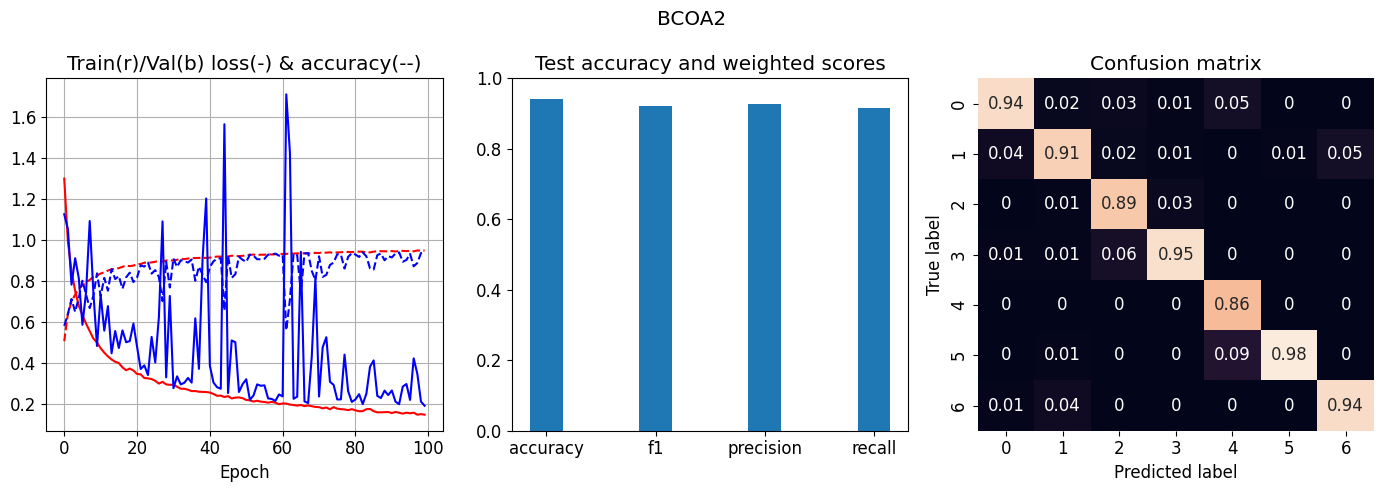

In [29]:
# We can plot the training/validation curves and task 1 results
epgs.plot_train_result()

In [14]:
# Write training log 
epgs.write_train_log()

In [40]:
# Save checkpoint
epgs.save_checkpoint(name = 'cnn1d.BCOA2.json')

Parameters saved to ./checkpoints/cnn1d/cnn1d.BCOA2.json.


## Load a pretrained model

In [32]:
# Get config
from utils.configs_utils import process_config
config = process_config('cnn1d.combined_data.256.json')
config 

{'exp_name': 'combined_data',
 'dataset_name': 99,
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'cnn1d',
 'method': 'raw',
 'scale': True,
 'outlier_filter': False,
 'optimizer': 'Adam',
 'n_epochs': 100,
 'lr': 0.0001,
 'batch_size': 256,
 'scope': 1,
 'data_path': '../data',
 'device': 'cuda',
 'timestamp': '2024-06-11 15:45:07'}

In [34]:
epgs = EPGS(config)
# load a trained model
cp = 'cnn1d.BCOA2.json'
epgs.load_checkpoint(cp)

Loading complete.


In [35]:
# predict 
pred_ana = epgs.segment(recording_name='BCOA2.test_BCOA-Wheat_01-15-18-day-ch3')

Overlap rate: 0.8590714299107152


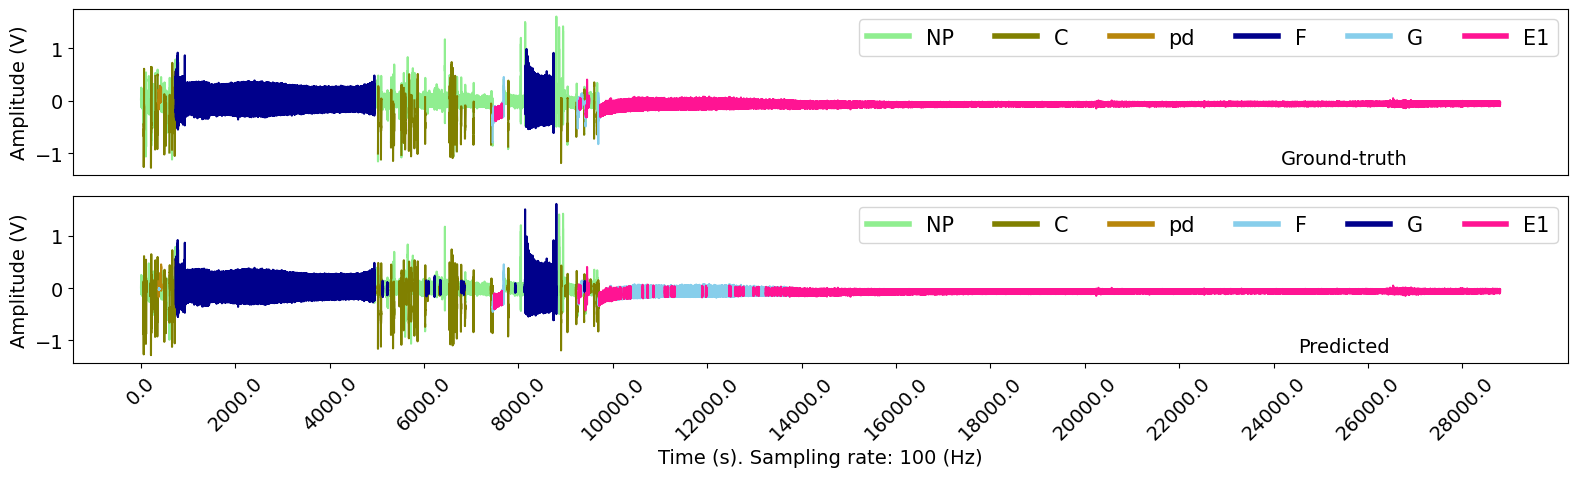

In [63]:
# plot 
print('Overlap rate:',epgs.overlap_rate)
epgs.plot_segmentation(which = 'pred_vs_gt', savefig = False, name = 'BCOA2.test_BCOA-Wheat_01-15-18-day-ch3')

In [41]:
# save analysis file 
epgs.save_analysis()

Analysis saved to ./prediction/ANA/Untitled_3.ANA


# EPGS_ML

Support XGB, RF, LogReg, SVC

In [50]:
# Get config
from utils.configs_utils import process_config

config = process_config('XGB.BCOA2.wavelet.json')
config 

{'exp_name': 'BCOA2',
 'dataset_name': 'BCOA2',
 'window_size': 1024,
 'hop_length': 1024,
 'arch': 'XGB',
 'method': 'wavelet',
 'scale': True,
 'outlier_filter': False,
 'n_epochs': 100,
 'scope': 4,
 'data_path': '../',
 'device': 'cuda',
 'timestamp': '2024-06-11 15:59:51'}

In [54]:
# Generate training data
# Feature calculation may takes a long time (Around 30-45 minutes for a total of 60 8-hour recordings)
# After that, the features matrix will be saved so that you will not have to calculate it again
from dataset_utils.MLdatagenerator import compute_features_matrix 
compute_features_matrix(config.dataset_name, config.method, config.window_size, config.hop_length)

Dataset BCOA2
Generating sliding windows ...


Subdataset BCOA-Wheat: 100%|██████████| 57/57 [00:43<00:00,  1.33it/s]


Computing training features matrices ...
wavelet


100%|██████████| 147124/147124 [14:37<00:00, 167.70it/s]


Computing testing features matrices ...
wavelet


100%|██████████| 36782/36782 [03:38<00:00, 168.08it/s]


Done. Elapsed computation time: 1097.6169590000063
Saving datasets ...


In [56]:
from dataset_utils.MLdatagenerator import read_dataset_from_config
from models.SegmentationML import EPGS_ML

In [57]:
epg = EPGS_ML(config)

X_train, X_test, y_train, y_test = read_dataset_from_config(config)

epg.fit(X_train, y_train)


Training...
Finished training. Elapsed time: 30.105 (s)


In [58]:
# Task 1 evaluation
pred = epg.predict(X_test, y_test)

Predicting ...
Accuracy: 0.9621, f1: 0.9554
Finished testing.


In [59]:
# Task 2 evaluation (segmentation)
pred_ana = epg.segment('BCOA2.test_BCOA-Wheat_01-15-18-day-ch3')
epg.save_analysis()

Generating segmentation ...


100%|██████████| 11247/11247 [01:06<00:00, 168.38it/s]


Overlapping rate: 0.8299238402248891


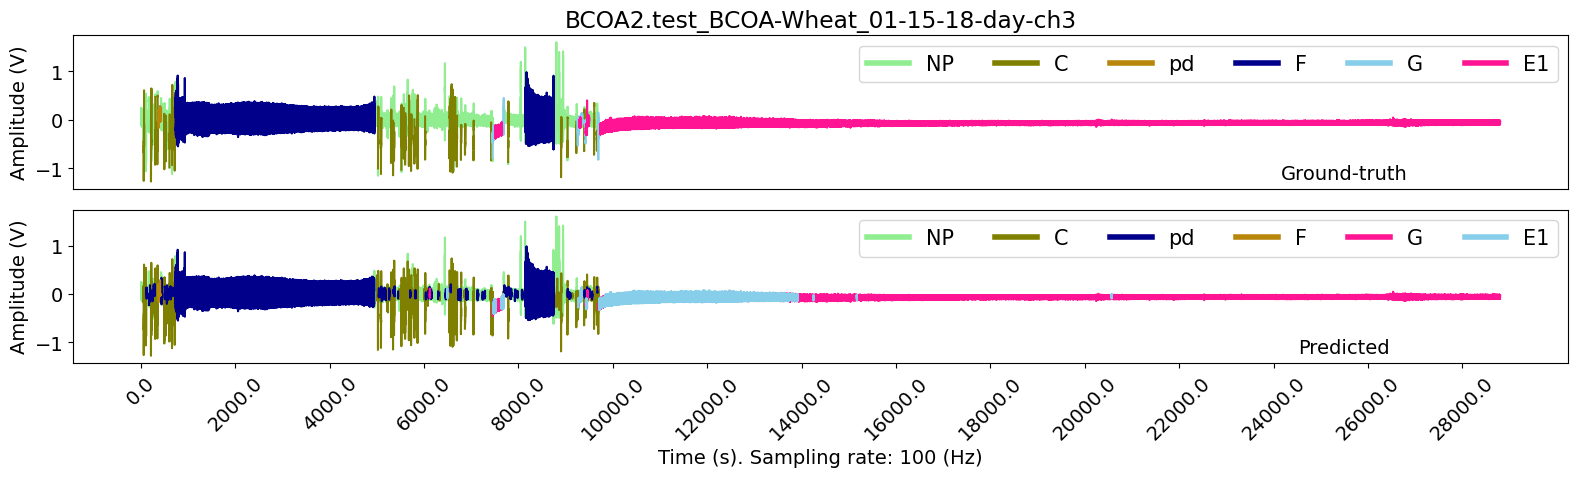

In [62]:
epg.plot_segmentation(which = 'pred_vs_gt')